In [1]:
import mpramnist
from mpramnist.evfratovdataset import EvfratovDataset

import mpramnist.transforms as t
import mpramnist.target_transforms as t_t

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import logging
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

In [2]:
BATCH_SIZE = 32
NUM_WORKERS = 103

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Some info

The dataset has a pair of attributes:

merge_last_classes — determines whether the last two classes should be merged into one.

length_of_seq — determines which dataset to use. "23" refers to the dataset with sequences of length 23, and "33" refers to the dataset with sequences of length 33. The default is "23".

## Define set of transforms

In [3]:
# preprocessing
train_transform = t.Compose([
    t.Seq2Tensor(),
    t.Reverse(0.5),
])

test_transform = t.Compose([ # test transforms are slightly different.
    t.Seq2Tensor(), 
    t.Reverse(0), # Reverse complementary transformation for all sequences with a probability of 0
])

## Merging last 2 classes

### 8 classes

The data initially has 8 labels. 

You can train the model on all 8 classes, but the number of instances in the last class is extremely small. 

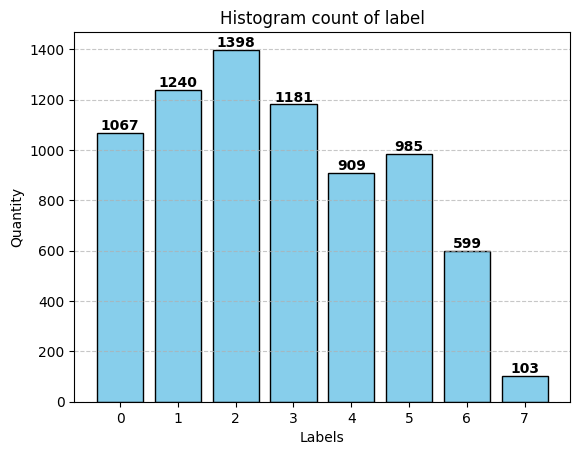

In [4]:
merge_last_classes = False

train_dataset = EvfratovDataset(split="train", merge_last_classes = merge_last_classes,
                              transform=train_transform) # use "train" for default training set or use list
train_dataset.hist_plot()

Therefore, to balance class representation, we propose merging the last two classes into one.

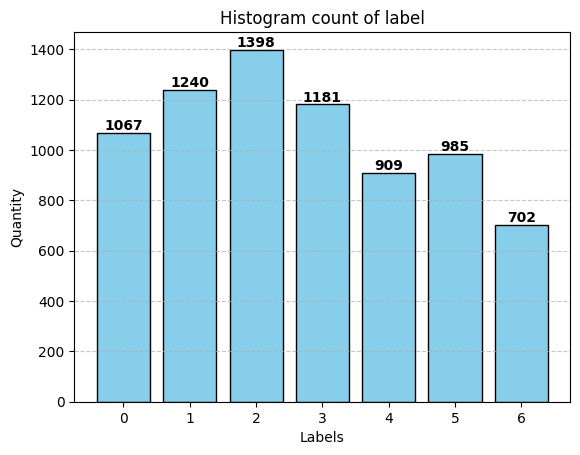

In [5]:
merge_last_classes = True

train_dataset = EvfratovDataset(split="train", merge_last_classes = merge_last_classes,
                              transform=train_transform) # use "train" for default training set or use list
train_dataset.hist_plot()

## First, Lets work with sequences length of 23

The default value of *length_of_seq* is 23

In [6]:
length_of_seq = 23
train_dataset = EvfratovDataset(split="train", merge_last_classes = merge_last_classes,
                              transform=train_transform) # use "train" for default training set or use list
val_dataset = EvfratovDataset(split="val", merge_last_classes = merge_last_classes,
                            transform=test_transform) # use "val" for default validation set or use list
test_dataset = EvfratovDataset(split="test", merge_last_classes = merge_last_classes,
                             transform=test_transform) # use "test" for default test set or use list

In [7]:
N_CLASSES = train_dataset.n_classes
in_channels = len(train_dataset[0][0])

In [8]:
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, auc, average_precision_score, roc_auc_score
from sklearn.metrics import accuracy_score, f1_score

from sklearn.preprocessing import label_binarize
from itertools import cycle

def calculate_auroc(y_score, y_true, n_classes, ax=None):

    y_score = F.softmax(y_score.float(), dim=1).cpu().numpy()
    y_true = y_true.cpu().numpy()

    y = label_binarize(y_true, classes=np.arange(n_classes))
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    lw = 1
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:,i], y_score[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    colors = ['orange', 'green', 'red', 'purple', 'brown', 'pink', 'blue', 'yellow', 'cyan']
    colors = cycle(colors[:n_classes])
    
    # Plot of a ROC curve for a specific class
    for i, color in zip(range(n_classes), colors):
        ax.plot(fpr[i], tpr[i], color=color, lw= 0.5,label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    
    ax.plot([0, 1], [0, 1], 'k--', lw=lw)
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic for multi-class data')
    ax.legend(loc="lower right")

    return roc_auc_score(
        y_true,
        y_score,
        multi_class="ovr",
        average="macro",
    )

def calculate_aupr(y_score, y_true, n_classes, ax=None):
    y_score = F.softmax(y_score.float(), dim=1).cpu().numpy()
    y_pred = np.argmax(y_score, axis=1)
    y_true = y_true.cpu().numpy()
    
    df = pd.DataFrame({"predicted" : y_pred})
    
    ax.bar(np.arange(n_classes), np.bincount(y_pred, minlength=n_classes), color='skyblue', edgecolor='black')
    for i, count in enumerate(np.bincount(y_pred, minlength=n_classes)):
        ax.text(i, count, str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Labels')
    ax.set_ylabel('Quantity')
    ax.set_title('Histogram count of label')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro')  
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')

    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
    pr_auc = average_precision_score(y_true_bin, y_score, average="macro")
    return precision, recall, accuracy, f1, pr_auc
    
def roc_auc(seq_model, loader, n_classes, figure=False):
    
    predictions = trainer.predict(seq_model, dataloaders=loader)
    
    targets = torch.cat([pred["y"] for pred in predictions])
    y_preds = torch.cat([pred["pred"] for pred in predictions])

    if figure:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # Создаем фигуру с двумя subplot'ами в одной строке

    auroc = calculate_auroc(y_preds, targets, n_classes, ax1 if figure else None) 
    precision, recall, accuracy, f1, aupr = calculate_aupr(y_preds, targets, n_classes, ax2 if figure else None) 
    
    res_str = '|' + ' {}: {:.5f} |'.format("Precision", precision)
    res_str += ' {}: {:.5f} |'.format("Recall", recall)
    res_str += ' {}: {:.5f} |'.format("Accuracy", accuracy)
    res_str += ' {}: {:.5f} |'.format("F1", f1)
    
    border = '-'*100
    print("\n".join(['',border, res_str, border,'']))
    
    print("Test AUROC: %.4f"%(np.nanmean(auroc)))
    print("Test AUPR: %.4f"%(np.nanmean(aupr)))

    if figure:
        plt.tight_layout()  # Автоматическая настройка отступов между subplot'ами
        plt.show()

# LegNet Model

In [9]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

def initialize_weights(m):
    if isinstance(m, nn.Conv1d):
        n = m.kernel_size[0] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2 / n))
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm1d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        m.weight.data.normal_(0, 0.001)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

class SELayer(nn.Module):
    def __init__(self, inp, reduction=4):
        super(SELayer, self).__init__()
        self.fc = nn.Sequential(
                nn.Linear(inp, int(inp // reduction)),
                nn.SiLU(),
                nn.Linear(int(inp // reduction), inp),
                nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, = x.size()
        y = x.view(b, c, -1).mean(dim=2)
        y = self.fc(y).view(b, c, 1)
        return x * y

class EffBlock(nn.Module):
    def __init__(self, in_ch, ks, resize_factor, activation, out_ch=None, se_reduction=None):
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = self.in_ch if out_ch is None else out_ch
        self.resize_factor = resize_factor
        self.se_reduction = resize_factor if se_reduction is None else se_reduction
        self.ks = ks
        self.inner_dim = self.in_ch * self.resize_factor

        block = nn.Sequential(
                        nn.Conv1d(
                            in_channels=self.in_ch,
                            out_channels=self.inner_dim,
                            kernel_size=1,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.inner_dim),
                       activation(),

                       nn.Conv1d(
                            in_channels=self.inner_dim,
                            out_channels=self.inner_dim,
                            kernel_size=ks,
                            groups=self.inner_dim,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.inner_dim),
                       activation(),
                       SELayer(self.inner_dim, reduction=self.se_reduction),
                       nn.Conv1d(
                            in_channels=self.inner_dim,
                            out_channels=self.in_ch,
                            kernel_size=1,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.in_ch),
                       activation(),
        )

        self.block = block

    def forward(self, x):
        return self.block(x)

class LocalBlock(nn.Module):
    def __init__(self, in_ch, ks, activation, out_ch=None):
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = self.in_ch if out_ch is None else out_ch
        self.ks = ks

        self.block = nn.Sequential(
                       nn.Conv1d(
                            in_channels=self.in_ch,
                            out_channels=self.out_ch,
                            kernel_size=self.ks,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.out_ch),
                       activation()
        )

    def forward(self, x):
        return self.block(x)

class ResidualConcat(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return torch.concat([self.fn(x, **kwargs), x], dim=1)

class MapperBlock(nn.Module):
    def __init__(self, in_features, out_features, activation=nn.SiLU):
        super().__init__()
        self.block = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Conv1d(in_channels=in_features,
                      out_channels=out_features,
                      kernel_size=1),
        )

    def forward(self, x):
        return self.block(x)

class HumanLegNet(nn.Module):
    def __init__(self,
                 in_ch,
                 output_dim,
                 stem_ch,
                 stem_ks,
                 ef_ks,
                 ef_block_sizes,
                 pool_sizes,
                 resize_factor,
                 activation=nn.SiLU,
                 ):
        super().__init__()
        assert len(pool_sizes) == len(ef_block_sizes)

        self.in_ch = in_ch
        self.output_dim = output_dim
        self.stem = LocalBlock(in_ch=in_ch,
                               out_ch=stem_ch,
                               ks=stem_ks,
                               activation=activation)

        blocks = []

        in_ch = stem_ch
        out_ch = stem_ch
        for pool_sz, out_ch in zip(pool_sizes, ef_block_sizes):
            blc = nn.Sequential(
                ResidualConcat(
                    EffBlock(
                        in_ch=in_ch,
                        out_ch=in_ch,
                        ks=ef_ks,
                        resize_factor=resize_factor,
                        activation=activation)
                ),
                LocalBlock(in_ch=in_ch * 2,
                           out_ch=out_ch,
                           ks=ef_ks,
                           activation=activation),
                nn.MaxPool1d(pool_sz) if pool_sz != 1 else nn.Identity()
            )
            in_ch = out_ch
            blocks.append(blc)
        self.main = nn.Sequential(*blocks)

        self.mapper = MapperBlock(in_features=out_ch,
                                  out_features=out_ch * 2)
        self.head = nn.Sequential(nn.Linear(out_ch * 2, out_ch * 2),
                                   nn.BatchNorm1d(out_ch * 2),
                                   activation(),
                                   nn.Linear(out_ch * 2, self.output_dim))

    def forward(self, x):
        x = self.stem(x)
        x = self.main(x)
        x = self.mapper(x)
        x =  F.adaptive_avg_pool1d(x, 1)
        x = x.squeeze(-1)
        x = self.head(x)
        x = x.squeeze(-1)
        return x

# Trainer

In [10]:
import pytorch_lightning as L
from torch.nn import functional as F
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize
    
class Seq1Model(L.LightningModule):
    
    def __init__(self, in_ch, out_ch, lr=3e-4):
        super().__init__()
        
        self.model = HumanLegNet(in_ch=in_ch,
                                 output_dim = out_ch,
                                 stem_ch=64,
                                 stem_ks=11,
                                 ef_ks=9,
                                 ef_block_sizes=[80, 96, 112, 128],
                                 pool_sizes=[2,2,2,2],
                                 resize_factor=4)
        self.model.apply(initialize_weights)
        

        self.loss = torch.nn.CrossEntropyLoss().to(device)
        self.lr = lr
        self.n_classes = out_ch

        self.val_loss = torch.tensor([], device=device)
        self.y_score = torch.tensor([], device=device)
        self.y_true = torch.tensor([], device=device)
        self.train_loss = torch.tensor([], device=device)

        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_nb):
        X, y = batch
        y_hat = self.model(X)
        y = y.long()

        loss = self.loss(y_hat, y)
        
        self.log("train_loss", loss, prog_bar=True,  on_step=True, on_epoch=True, logger = True)
        self.train_loss = torch.cat([self.train_loss, loss.unsqueeze(0)])
        
        lr = self.optimizers().param_groups[0]['lr']  # Get current learning rate
        self.log('learning_rate', lr, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        y = y.long()

        loss = self.loss(y_hat, y)
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)

        self.val_loss = torch.cat([self.val_loss, loss.unsqueeze(0)])
        self.y_score = torch.cat([self.y_score, y_hat])
        self.y_true = torch.cat([self.y_true, y])
        
    def on_validation_epoch_end(self):
        
        val_loss = self.val_loss.mean()
        
        auroc = self.calculate_auroc(y_score=self.y_score, y_true=self.y_true, n_classes=self.n_classes) 
        arr, precision, recall, accuracy, f1, aupr = self.calculate_aupr(y_score=self.y_score, y_true=self.y_true, n_classes=self.n_classes) 
        
        res_str = '|' + ' {}: {:.5f} |'.format("Current_epoch", self.current_epoch) 
        res_str += ' {}: {:.5f} |'.format("Val_loss", val_loss)
        res_str += ' {}: {:.5f} |'.format("Val_AUCROC", auroc)
        res_str += ' {}: {:.5f} |'.format("Val_AUPR", aupr)
        res_str += "\n"
        res_str += "|"
        res_str += ' {}: {} |'.format("Number of predicted values", arr)
        res_str += "\n"
        res_str += "|"
        res_str += ' {}: {:.5f} |'.format("Precision", precision)
        res_str += ' {}: {:.5f} |'.format("Recall", recall)
        res_str += ' {}: {:.5f} |'.format("Accuracy", accuracy)
        res_str += ' {}: {:.5f} |'.format("F1", f1)
        if len(self.train_loss) != 0: 
            train_loss = self.train_loss.mean()
            res_str += ' {}: {:.5f} |'.format("Train_loss", train_loss)
            self.train_loss = torch.tensor([], device=device)
        
        border = '-'*100
        print("\n".join(['',border, res_str, border,'']))
        
        self.val_loss = torch.tensor([], device=device)
        self.y_score = torch.tensor([], device=device)
        self.y_true = torch.tensor([], device=device)

        return None

    def test_step(self, batch, _):
        x, y = batch
        y_hat = self.model(x)
        y = y.long()

        loss = self.loss(y_hat, y)
        self.log('test_loss', 
                 loss, 
                 prog_bar=True, 
                 on_step=False,
                 on_epoch=True)

    def calculate_auroc(self, y_score, y_true, n_classes):
        y_score = F.softmax(y_score.float(), dim=1).cpu().numpy()
        y_true = y_true.cpu().numpy()

        y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
        
        return roc_auc_score(y_true_bin, y_score, multi_class="ovr", average="macro")

    def calculate_aupr(self, y_score, y_true, n_classes):
        y_score = F.softmax(y_score.float(), dim=1).cpu().numpy()
        y_pred = np.argmax(y_score, axis=1)
        y_true = y_true.cpu().numpy()
        
        arr = []
        for i in range(n_classes):
            arr.append(y_pred.tolist().count(i))
        
        precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_true, y_pred, average='macro', zero_division = 0)  
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro')

        y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
        pr_auc = average_precision_score(y_true_bin, y_score, average="macro")
        return arr, precision, recall, accuracy, f1, pr_auc

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y_hat = self.model(x)          
        
        return {"y": y.squeeze().long().cpu().detach().float(), "pred": y_hat.cpu().detach().float()}

    def train_dataloader(self):
        return data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS, pin_memory=True)

    def val_dataloader(self):
        return data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS, pin_memory=True)
    
    def test_dataloader(self):
        return data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS, pin_memory=True)

    def configure_optimizers(self):
        
        self.optimizer = torch.optim.AdamW(self.parameters(),
                                               lr=self.lr,
                                               weight_decay = 1e-2)
        
        lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, # type: ignore
                                                        max_lr=self.lr,
                                                        three_phase=False, 
                                                        total_steps=self.trainer.estimated_stepping_batches, # type: ignore
                                                        pct_start=0.3,
                                                        cycle_momentum =False)
        lr_scheduler_config = {
                    "scheduler": lr_scheduler,
                    "interval": "step",
                    "frequency": 1,
                    "name": "cycle_lr"
            }
            
        return [self.optimizer], [lr_scheduler_config]


# Training

In [11]:
seq_model = Seq1Model(in_ch = in_channels, out_ch = N_CLASSES, lr = 1e-2)

# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=5,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = True,
)

# Train the model
trainer.fit(seq_model)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2025-03-22 11:24:12.554649: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-22 11:24:12.570558: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one 

Sanity Checking: |                                                                                | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 0.00000 | Val_loss: 1.94629 | Val_AUCROC: 0.40799 | Val_AUPR: 0.16584 |
| Number of predicted values: [41, 15, 0, 0, 0, 8, 0] |
| Precision: 0.02950 | Recall: 0.14286 | Accuracy: 0.07812 | F1: 0.04389 |
----------------------------------------------------------------------------------------------------



Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 0.00000 | Val_loss: 2.88070 | Val_AUCROC: 0.61320 | Val_AUPR: 0.25090 |
| Number of predicted values: [3, 627, 205, 3, 0, 134, 899] |
| Precision: 0.21267 | Recall: 0.24491 | Accuracy: 0.23463 | F1: 0.14010 | Train_loss: 1.74015 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 1.00000 | Val_loss: 1.50000 | Val_AUCROC: 0.79484 | Val_AUPR: 0.37934 |
| Number of predicted values: [18, 448, 573, 12, 428, 0, 392] |
| Precision: 0.32047 | Recall: 0.35480 | Accuracy: 0.34687 | F1: 0.26371 | Train_loss: 1.61859 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 2.00000 | Val_loss: 1.32878 | Val_AUCROC: 0.84184 | Val_AUPR: 0.44508 |
| Number of predicted values: [195, 329, 553, 319, 12, 275, 188] |
| Precision: 0.41777 | Recall: 0.42753 | Accuracy: 0.43079 | F1: 0.40675 | Train_loss: 1.48002 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 3.00000 | Val_loss: 1.27353 | Val_AUCROC: 0.84911 | Val_AUPR: 0.44769 |
| Number of predicted values: [334, 297, 478, 220, 178, 234, 130] |
| Precision: 0.46654 | Recall: 0.44995 | Accuracy: 0.45056 | F1: 0.45114 | Train_loss: 1.35458 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=5` reached.



----------------------------------------------------------------------------------------------------
| Current_epoch: 4.00000 | Val_loss: 1.22666 | Val_AUCROC: 0.86040 | Val_AUPR: 0.48243 |
| Number of predicted values: [316, 304, 404, 264, 143, 282, 158] |
| Precision: 0.50279 | Recall: 0.49586 | Accuracy: 0.48958 | F1: 0.49409 | Train_loss: 1.24631 |
----------------------------------------------------------------------------------------------------



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Precision: 0.49933 | Recall: 0.49911 | Accuracy: 0.49124 | F1: 0.49732 |
----------------------------------------------------------------------------------------------------

Test AUROC: 0.8583
Test AUPR: 0.4918


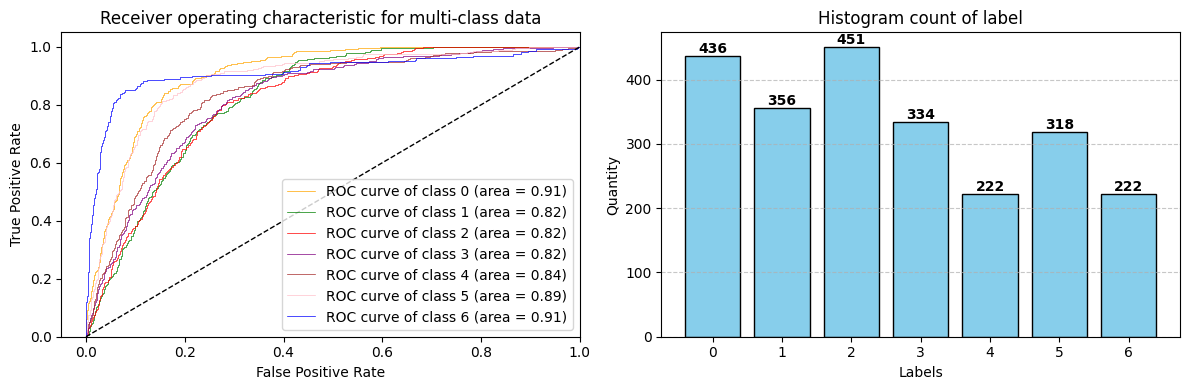

In [12]:
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)
roc_auc(seq_model, test_loader, n_classes = N_CLASSES, figure = True)

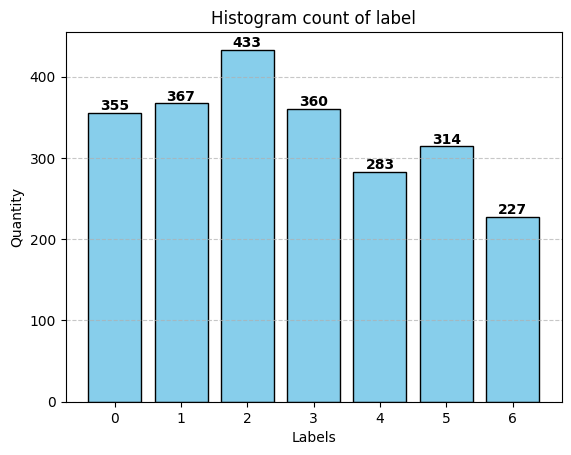

In [13]:
test_dataset.hist_plot()

## Second, Lets try with sequences length of 33

In [14]:
length_of_seq = 33
merge_last_classes = False

train_dataset = EvfratovDataset(split="train", merge_last_classes = merge_last_classes, 
                                length_of_seq = length_of_seq,
                              transform=train_transform) 
val_dataset = EvfratovDataset(split="val", merge_last_classes = merge_last_classes,
                              length_of_seq = length_of_seq,
                            transform=test_transform) 
test_dataset = EvfratovDataset(split="test", merge_last_classes = merge_last_classes,
                               length_of_seq = length_of_seq,
                             transform=test_transform) 

N_CLASSES = train_dataset.n_classes
in_channels = len(train_dataset[0][0])

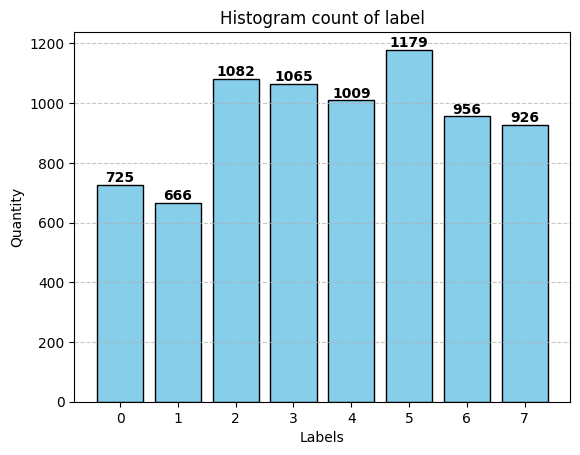

In [15]:
train_dataset.hist_plot()

# Training

In [16]:
seq_model = Seq1Model(in_ch = in_channels, out_ch = N_CLASSES, lr = 1e-2)

# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=10,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = True,
    num_sanity_val_steps=0
)

# Train the model
trainer.fit(seq_model)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | HumanLegNet      | 1.3 M  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.297     Total estimated model params size (MB)
117       Modules in train mode
0         Modules in eval mode


Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 0.00000 | Val_loss: 2.04826 | Val_AUCROC: 0.67873 | Val_AUPR: 0.21516 |
| Number of predicted values: [154, 0, 139, 326, 3, 1060, 2, 219] |
| Precision: 0.16058 | Recall: 0.21116 | Accuracy: 0.21965 | F1: 0.16174 | Train_loss: 1.92605 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 1.00000 | Val_loss: 1.78367 | Val_AUCROC: 0.73798 | Val_AUPR: 0.27552 |
| Number of predicted values: [486, 0, 0, 403, 120, 690, 0, 204] |
| Precision: 0.19022 | Recall: 0.28121 | Accuracy: 0.28008 | F1: 0.20818 | Train_loss: 1.84836 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 2.00000 | Val_loss: 1.64310 | Val_AUCROC: 0.78441 | Val_AUPR: 0.32190 |
| Number of predicted values: [28, 395, 482, 12, 178, 425, 91, 292] |
| Precision: 0.35544 | Recall: 0.31762 | Accuracy: 0.30899 | F1: 0.27303 | Train_loss: 1.75258 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 3.00000 | Val_loss: 1.61310 | Val_AUCROC: 0.79466 | Val_AUPR: 0.33821 |
| Number of predicted values: [257, 70, 72, 424, 269, 290, 446, 75] |
| Precision: 0.35335 | Recall: 0.31640 | Accuracy: 0.31844 | F1: 0.29797 | Train_loss: 1.65856 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 4.00000 | Val_loss: 1.53435 | Val_AUCROC: 0.81470 | Val_AUPR: 0.37587 |
| Number of predicted values: [224, 0, 495, 129, 173, 560, 71, 251] |
| Precision: 0.31909 | Recall: 0.36049 | Accuracy: 0.36311 | F1: 0.31426 | Train_loss: 1.60766 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 5.00000 | Val_loss: 1.46222 | Val_AUCROC: 0.83399 | Val_AUPR: 0.39794 |
| Number of predicted values: [255, 0, 373, 111, 219, 522, 93, 330] |
| Precision: 0.32522 | Recall: 0.38232 | Accuracy: 0.38098 | F1: 0.33034 | Train_loss: 1.53677 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 6.00000 | Val_loss: 1.41894 | Val_AUCROC: 0.84568 | Val_AUPR: 0.41908 |
| Number of predicted values: [266, 53, 356, 331, 37, 461, 185, 214] |
| Precision: 0.42727 | Recall: 0.41411 | Accuracy: 0.41513 | F1: 0.38481 | Train_loss: 1.47625 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 7.00000 | Val_loss: 1.37996 | Val_AUCROC: 0.85095 | Val_AUPR: 0.42391 |
| Number of predicted values: [182, 118, 366, 188, 182, 422, 238, 207] |
| Precision: 0.42958 | Recall: 0.42221 | Accuracy: 0.41934 | F1: 0.41695 | Train_loss: 1.39771 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 8.00000 | Val_loss: 1.36474 | Val_AUCROC: 0.85531 | Val_AUPR: 0.43424 |
| Number of predicted values: [244, 0, 387, 244, 189, 340, 230, 269] |
| Precision: 0.37502 | Recall: 0.42180 | Accuracy: 0.42407 | F1: 0.39208 | Train_loss: 1.31594 |
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Current_epoch: 9.00000 | Val_loss: 1.35453 | Val_AUCROC: 0.85696 | Val_AUPR: 0.43378 |
| Number of predicted values: [234, 0, 373, 264, 224, 393, 229, 186] |
| Precision: 0.39948 | Recall: 0.42732 | Accuracy: 0.43300 | F1: 0.40669 | Train_loss: 1.25141 |
----------------------------------------------------------------------------------------------------



`Trainer.fit` stopped: `max_epochs=10` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Precision: 0.40825 | Recall: 0.43531 | Accuracy: 0.44407 | F1: 0.41695 |
----------------------------------------------------------------------------------------------------

Test AUROC: 0.8542
Test AUPR: 0.4367


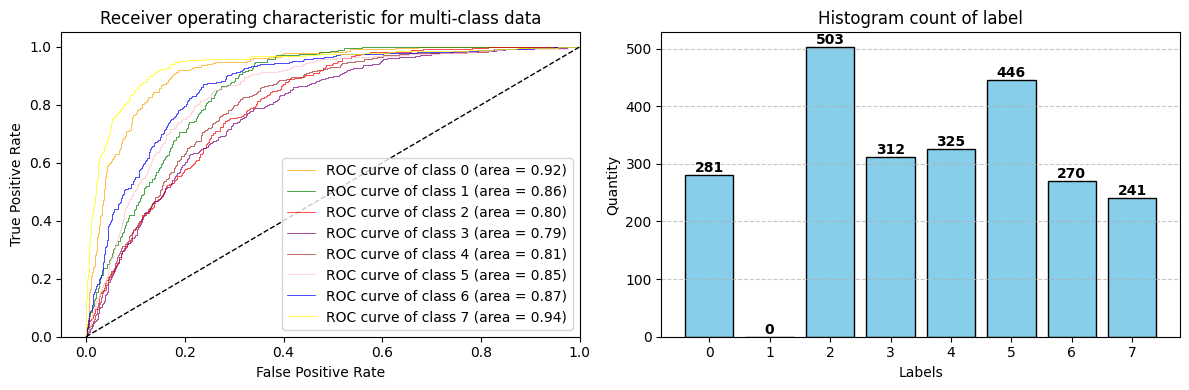

In [17]:
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)
roc_auc(seq_model, test_loader, n_classes = N_CLASSES, figure = True)

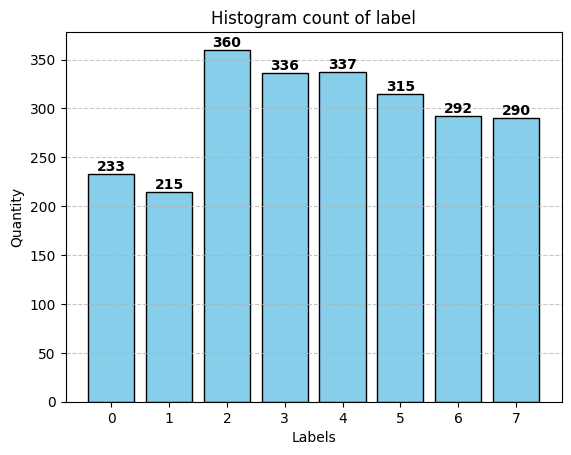

In [18]:
test_dataset.hist_plot()